In [2]:
import numpy as np
import pandas as pd
import pydicom as dicom
import cv2
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [3]:
labels = pd.read_csv('data/stage_2_train_labels.csv')
detailed_labels = pd.read_csv('data/stage_2_detailed_class_info.csv')

In [4]:
unique_labels = labels.drop_duplicates(['patientId'])
unique_detailed_labels = detailed_labels.drop_duplicates(['patientId'])

In [5]:
unique_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [6]:
dicom.dcmread('data/stage_2_train_images/0a0f91dc-6015-4342-b809-d19610854a21.dcm').pixel_array

array([[246, 245, 241, ..., 231, 252, 153],
       [242, 242, 239, ..., 231, 251, 151],
       [239, 239, 237, ..., 230, 250, 150],
       ...,
       [151, 149, 149, ..., 215, 243, 151],
       [148, 146, 145, ..., 215, 243, 150],
       [146, 145, 146, ..., 217, 244, 151]], dtype=uint8)

In [7]:


class TrainDatasetClassif(Dataset):
    def __init__(self, root, unique_labels, transforms=None):
        self.transforms = transforms
        self.root = root
        self.unique_labels = unique_labels
        
    def __len__(self):
        return len(self.unique_labels)
    
    def __getitem__(self, idx):
        image_path = self.root + self.unique_labels.iloc[idx, 0] + '.dcm'
        image = dicom.dcmread(image_path).pixel_array
        label = self.unique_labels.loc[idx, 'Target']
        
        image = np.expand_dims(image, axis=-1)
        if self.transforms:
            image = self.transforms(image)
        
        return image, label

In [8]:
transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.uint8),
        transforms.Resize((320, 320), antialias=True),
#         transforms.Lambda(lambda x: transforms.functional.invert(x)),
#         transforms.RandomAffine(degrees=(-10,10), translate=(0.1, 0.1)),
#         transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
        transforms.ConvertImageDtype(torch.float32)
    ])

In [10]:
train_ds_classif = TrainDatasetClassif('data/stage_2_train_images', unique_labels, transformer)

In [11]:
train_loader = DataLoader(train_ds_classif, batch_size=64, shuffle=True, num_workers=4)

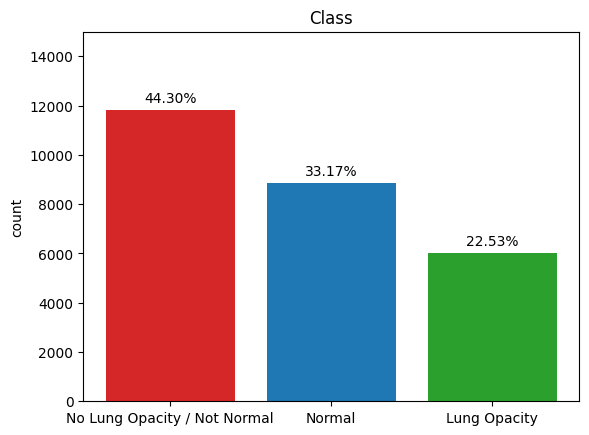

In [12]:
df = unique_detailed_labels
class_names = df['class'].value_counts().index
class_counts = df['class'].value_counts().values
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

fig, ax = plt.subplots()
ax.bar(class_names, class_counts, color=bar_colors)
ax.set(ylabel='count', title='Class', ylim=(0, 15000))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 300,
            '{:1.2f}%'.format(100*height/len(df)),
            ha="center") 
plt.show()

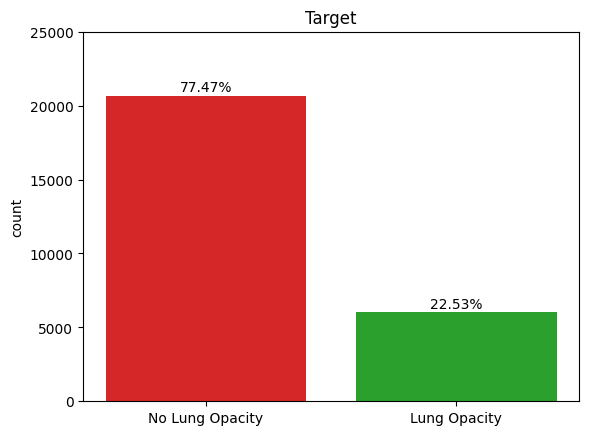

In [13]:
df = unique_labels
class_names = ['No Lung Opacity','Lung Opacity']
class_counts = df['Target'].value_counts().values
bar_colors = ['tab:red', 'tab:green']

fig, ax = plt.subplots()
ax.bar(class_names, class_counts, color=bar_colors)
ax.set(ylabel='count', title='Target', ylim=(0, 25000))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 300,
            '{:1.2f}%'.format(100*height/len(df)),
            ha="center") 

plt.show()

In [14]:
unique_labels = pd.merge(unique_labels, unique_detailed_labels, how='inner')

In [15]:
unique_labels.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


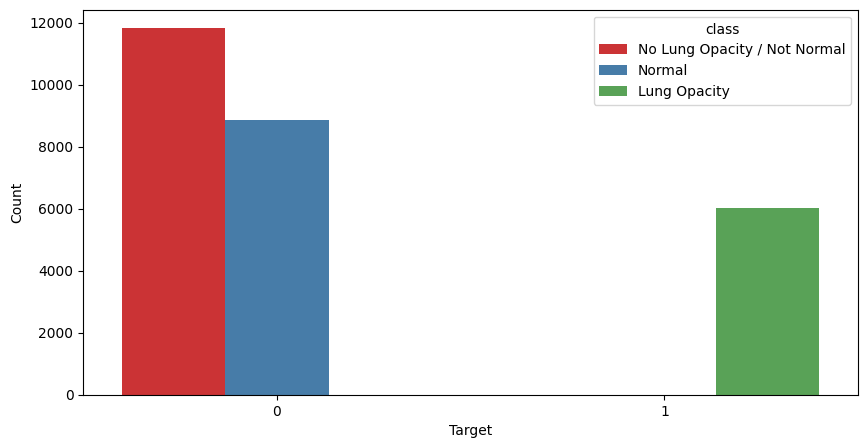

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
tmp = unique_labels.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Count': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Count',hue='class',data=df, palette='Set1')
plt.show()

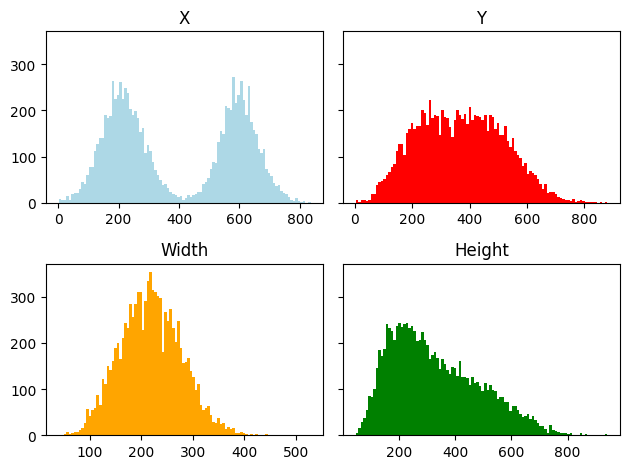

In [17]:
fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True)

n_bins = 100

axs[0,0].hist(labels.dropna()['x'], bins=n_bins, color = "lightblue")
axs[0,0].set_title('X')
axs[0,1].hist(labels.dropna()['y'], bins=n_bins, color = "red")
axs[0,1].set_title('Y')
axs[1,0].hist(labels.dropna()['width'], bins=n_bins, color = "orange")
axs[1,0].set_title('Width')
axs[1,1].hist(labels.dropna()['height'], bins=n_bins, color = "green")
axs[1,1].set_title('Height')

plt.show()

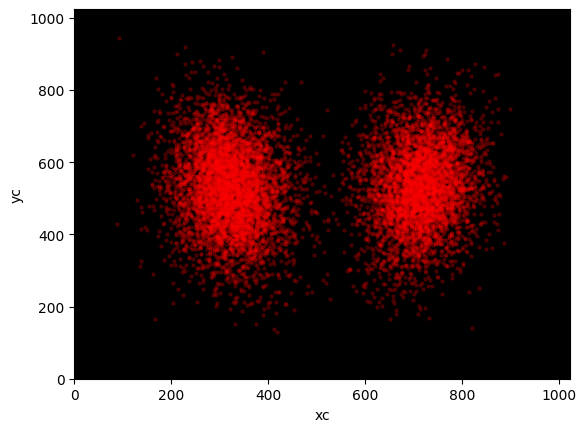

In [18]:
lung_opacity_position = pd.DataFrame()

lung_opacity_position['xc'] = labels['x'] + labels['width'] / 2
lung_opacity_position['yc'] = labels['y'] + labels['height'] / 2


fig, ax = plt.subplots()
ax.set_facecolor('black')
lung_opacity_position.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), 
                           ax=ax, alpha=0.2, marker=".", color="red")

plt.show()